# Distance Lattice Gym

In this document, The distance lattice is being generated for all possible gym entrances: the voxels on ground level on the south side of the building. 

## 0. Initialization

### 0.1. Load required libraries

In [18]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
import networkx as nx
np.random.seed(0)
from scipy.interpolate import RegularGridInterpolator

### 0.2. Define the Neighborhood (Stencil)

In [19]:
# creating neighborhood definition
stencil = tg.create_stencil("von_neumann", 1, 1)
# setting the center to zero
stencil.set_index([0,0,0], 0)
print(stencil)

[[[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 1 0]
  [1 0 1]
  [0 1 0]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]]]


### 0.3. Load the envelope lattice as the avialbility lattice

In [20]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/voxelized_envelope_lowres.csv')
avail_lattice = tg.lattice_from_csv(lattice_path)
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)

# loading the lattice from csv
lattice_path = os.path.relpath('../data/voxelized_envelope_highres.csv')
avail_lattice_highres = tg.lattice_from_csv(lattice_path)

In [21]:
p = pv.Plotter(notebook=True)

# adding the avilability lattice
init_avail_lattice.fast_vis(p)

p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(253.83650750405351, 163.83650750405351, 238.83650750405351),
 (30.0, -60.0, 15.0),
 (0.0, 0.0, 1.0)]

## 1. Distance Field Construction

### 1.1. Extract the connectivity graph from the lattice based on the defined stencil

In [22]:
# find the number of all voxels
vox_count = avail_lattice.size 

# initialize the adjacency matrix
adj_mtrx = np.zeros((vox_count,vox_count))

# Finding the index of the available voxels in avail_lattice
full_lattice = avail_lattice * 0 + 1
avail_index = np.array(np.where(full_lattice == 1)).T


# fill the adjacency matrix using the list of all neighbours
for vox_loc in avail_index:
    # find the 1D id
    vox_id = np.ravel_multi_index(vox_loc, avail_lattice.shape)
    # retrieve the list of neighbours of the voxel based on the stencil
    vox_neighs = avail_lattice.find_neighbours_masked(stencil, loc = vox_loc)
    # iterating over the neighbours
    for neigh in vox_neighs:
        # setting the entry to one
        adj_mtrx[vox_id, neigh] = 1.0

# construct the graph 
g = nx.from_numpy_array(adj_mtrx)

### 1.2. Compute distances on the graph

In [23]:
# compute the distance of all voxels to all voxels using floyd warshal algorithm
dist_mtrx = nx.floyd_warshall_numpy(g)

### 1.3. Select the entrance voxel options for public space

In [24]:
p = pv.Plotter(notebook=True)

# initialize the selection lattice
base_lattice = avail_lattice * 0 - 1

# init base flat
base_flat = base_lattice.flatten().astype(int)

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(base_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = base_lattice.minbound - base_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = base_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding the avilability lattice
init_avail_lattice.fast_vis(p)

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#aaaaaa")

def create_mesh(value):
    i = int(value)
    # init base flat
    base_copy = np.copy(base_lattice)
    base_copy = base_copy * 0 -1
    base_copy[-i, :, i] = 0 
    base_new = base_copy

    grid.cell_arrays["Selection"] = base_copy.flatten(order="F").astype(int) # Flatten the array!
    # filtering the voxels
    threshed = grid.threshold([-0.1, 0.9])
    # adding the voxels
    p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=False)

    return

p.add_slider_widget(create_mesh, [0, base_lattice.shape[1]], title='1D Index', value=0, event_type="always", style="classic", pointa=(0.1, 0.1), pointb=(0.9, 0.1))
p.show(use_ipyvtk=True)

# question: why do the selected voxels only change in diagonal direction? 
# question: why is it that it takes voxels outside the available lattice?

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(253.83650750405351, 163.83650750405351, 238.83650750405351),
 (30.0, -60.0, 15.0),
 (0.0, 0.0, 1.0)]

### 1.4. Construct Distance to Entrance Lattice 

In [ ]:
# create an empty lattice
base_lattice = avail_lattice * 0 
# select all entrance options;
base_lattice[-1,:,0] = 1 
base_flat = base_lattice.flatten()
# make a list out of selected entrance options
vox_interest = np.where(base_flat == 1 )

In [26]:
ent_dist = dist_mtrx[vox_interest]

#find the maximum valid value
max_valid = np.ma.masked_invalid(ent_dist).max()

# set the infinities to one more than the maximum valid values
ent_dist[ent_dist == np.inf] = max_valid + 1

min_dist = np.min(ent_dist, axis=0)

# mapping the values from (0, max) to (1, 0)
min_dist = 1 - min_dist / np.max(min_dist)

# constructing the lattice
ent_acc_lattice = tg.to_lattice(min_dist.reshape(avail_lattice.shape), avail_lattice)

### 1.5. Interpolation

In [29]:
def interpolate(info_lowres, base_highres):
    # line spaces
    x_space = np.linspace(info_lowres.minbound[0], info_lowres.maxbound[0],info_lowres.shape[0])
    y_space = np.linspace(info_lowres.minbound[1], info_lowres.maxbound[1],info_lowres.shape[1])
    z_space = np.linspace(info_lowres.minbound[2], info_lowres.maxbound[2],info_lowres.shape[2])

    # interpolation function
    interpolating_function = RegularGridInterpolator((x_space, y_space, z_space), info_lowres, bounds_error=False, fill_value=None)

    # high_res lattice
    full_lattice = base_highres + 1

    # sample points
    sample_points = full_lattice.centroids

    # interpolation
    interpolated_values = interpolating_function(sample_points)

    # lattice construction
    info_highres = tg.to_lattice(interpolated_values.reshape(base_highres.shape), base_highres)

    # nulling the unavailable cells
    info_highres *= base_highres

    return info_highres

In [30]:
ent_acc_highres = interpolate(ent_acc_lattice, avail_lattice_highres)

### 1.6. Visualize and save the distance lattice

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

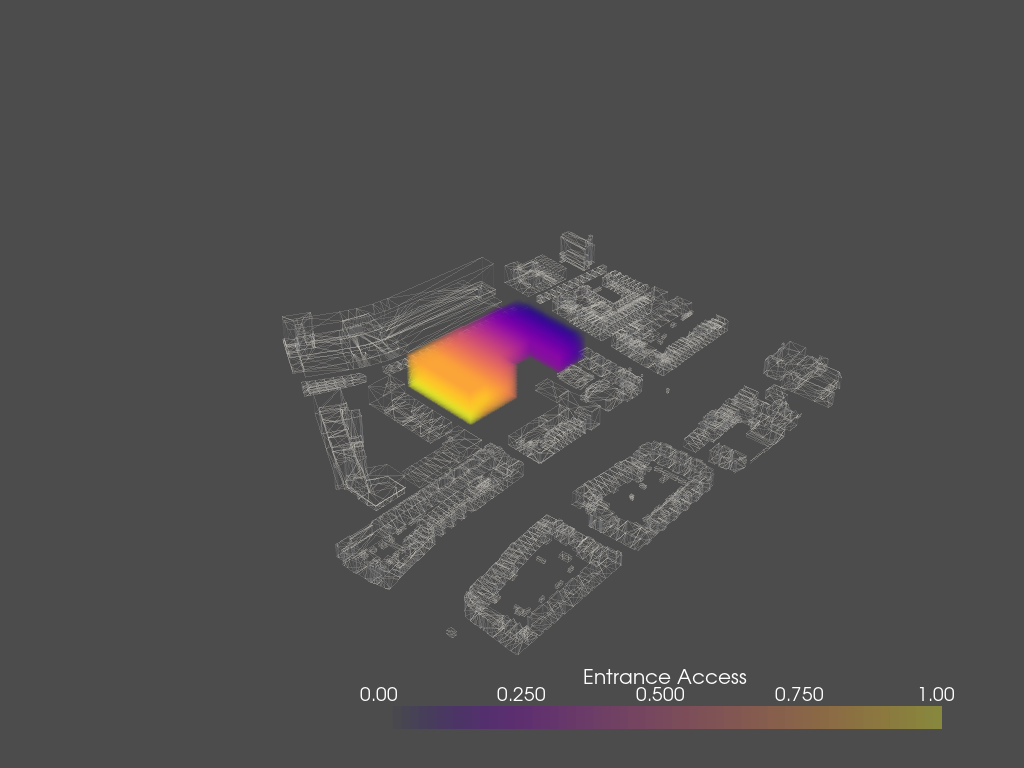

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [32]:
# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

# load the mesh from file
context_path = os.path.relpath('../data/immediate_context.obj')
context_mesh = tm.load(context_path)

# initiating the plotter
p = pv.Plotter(notebook=True)

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = ent_acc_highres.shape
# The bottom left corner of the data set
grid.origin = ent_acc_highres.minbound
# These are the cell sizes along each axis
grid.spacing = ent_acc_highres.unit

# Add the data values to the cell data
grid.point_arrays["Entrance Access"] = ent_acc_highres.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# adding the volume
opacity = np.array([0.0,0.6,0.6,0.6,0.6,0.6,0.6]) * 0.6
p.add_volume(grid, cmap="plasma", clim=[0.0, 1.0] ,opacity=opacity)

# plotting
p.show(use_ipyvtk=True)

#saving and plotting
png_path = os.path.relpath('../screenshots/3.4_lattice_gym.png')
p.show(screenshot= png_path)

### 1.7. Save Entrance Access Lattice to CSV

In [54]:
# save the entrance access lattice to csv
csv_path = os.path.relpath('../data/ent_access_highres_gym.csv')
ent_acc_highres.to_csv(csv_path)

### Credits

In [55]:
__author__ = "Shervin Azadi and Pirouz Nourian"
__editor__ = "Maartje Damen"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on MCDA and Path Finding for Generative Spatial Relations"